In [1]:
import sys
import numpy as np
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [2]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.simulation import mc_student_t_returns, ewma_covariance
from riskmc.risk_metrics import var, cvar, kupiec_test
from riskmc.plots import plot_t_pnl_distribution
from riskmc.plots import plot_gaussian_pnl_distribution
from riskmc.data import create_data
from riskmc.backtest import backtest_var

In [3]:
assets = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD']
weights = [0.45, 0.30, 0.15, 0.10]

N_SIMS = 100_000
HORIZON = 1

In [4]:
project_root = Path('..').resolve()
data_out_path = project_root / 'data' / 'prices.csv'
create_data(data_out_path, tickers=assets)

Saved 503 rows to /Users/ankithrangan/Desktop/Portfolio-risk-monte-carlo/data/prices.csv


Ticker,BTC-USD,ETH-USD,SOL-USD,BNB-USD
Date,,,,
2026-01-30,84128.656250,2702.375244,117.363037,857.258728
2026-02-02,78688.765625,2344.356689,104.471153,774.579285
2026-02-03,75633.546875,2227.558838,97.563904,753.578186
2026-02-04,73019.703125,2143.504150,92.029305,697.861755
2026-02-05,62841.820312,1823.146973,78.598480,609.785339


In [5]:
prices = load_prices(data_out_path)
rets = log_returns(prices)

print(rets)
print(prices)

             BTC-USD   ETH-USD   SOL-USD   BNB-USD
Date                                              
2024-02-06  0.009937  0.031393  0.013642  0.006151
2024-02-07  0.028229  0.021495  0.041638  0.016137
2024-02-08  0.021946 -0.001585  0.017730  0.035877
2024-02-09  0.039933  0.027556  0.039560  0.015467
2024-02-12  0.057913  0.066333  0.046229  0.012588
...              ...       ...       ...       ...
2026-01-30 -0.005133 -0.041979 -0.002066 -0.011412
2026-02-02 -0.066847 -0.142120 -0.116361 -0.101420
2026-02-03 -0.039600 -0.051105 -0.068403 -0.027487
2026-02-04 -0.035171 -0.038464 -0.058401 -0.076812
2026-02-05 -0.150109 -0.161878 -0.157755 -0.134914

[502 rows x 4 columns]
                 BTC-USD      ETH-USD     SOL-USD     BNB-USD
Date                                                         
2024-02-05  42658.667969  2298.888916   95.548660  300.854034
2024-02-06  43084.671875  2372.201904   96.861076  302.710144
2024-02-07  44318.222656  2423.745117  100.979279  307.634583
202

In [6]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2024-02-06    0.016551
2024-02-07    0.027011
2024-02-08    0.015647
2024-02-09    0.033717
2024-02-12    0.054154
                ...   
2026-01-30   -0.016355
2026-02-02   -0.100313
2026-02-03   -0.046161
2026-02-04   -0.043807
2026-02-05   -0.153267
Length: 502, dtype: float64


In [7]:
#monte carlo sim: gaussian
sim_gaussian_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON, ewma=True)
sim_gaussian_port_returns = sim_gaussian_asset_returns @ weights

#monte carlo sim: student-t
sim_t_asset_returns = mc_student_t_returns(rets, N_SIMS, HORIZON, ewma=True, nu=5)
sim_t_port_returns = sim_t_asset_returns @ weights


#returns: gaussian
print(sim_gaussian_asset_returns)
print(sim_gaussian_port_returns)

[[-0.02431311 -0.01465817 -0.02722566  0.00061087]
 [ 0.09501732  0.11782161  0.11007657  0.10739565]
 [-0.00840596  0.00726985 -0.00776407  0.01307368]
 ...
 [ 0.02456418  0.02287948  0.02260038  0.03143401]
 [ 0.06688706  0.06834513  0.09103014  0.04691267]
 [-0.06172621 -0.05009578 -0.03084635 -0.06454176]]
[-0.01936112  0.10535533 -0.00145897 ...  0.02445118  0.0689485
 -0.05388666]


In [8]:
#risk metrics: gaussian
var_gaussian_95 = var(sim_gaussian_port_returns, 0.95)
var_gaussian_99 = var(sim_gaussian_port_returns, 0.99)
cvar_gaussian_95 = cvar(sim_gaussian_port_returns, 0.95)
cvar_gaussian_99 = cvar(sim_gaussian_port_returns, 0.99)

var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99

(np.float64(0.08858593258665201),
 np.float64(0.12469830655356692),
 np.float64(0.11092368769303666),
 np.float64(0.1434805041755309))

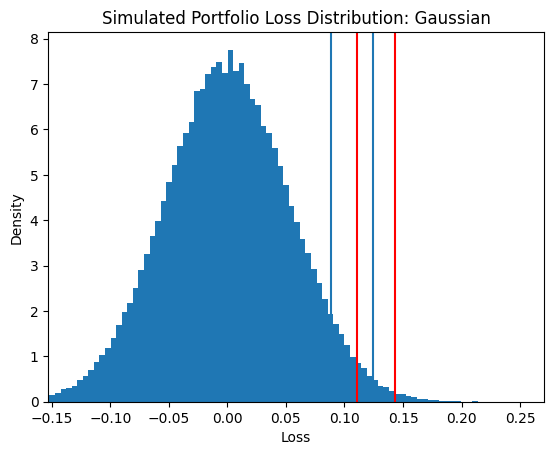

In [9]:
#plot: gaussian
plot_gaussian_pnl_distribution(sim_gaussian_port_returns, sim_t_port_returns, var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99)

In [10]:
print(np.std(sim_gaussian_port_returns))
print(np.mean(sim_gaussian_port_returns))

0.053677042341553724
-8.316628930653532e-05


In [11]:
#risk metrics: student-t
#here difference between VaR and CVaR is a lot more noticeabe
var_t_95 = var(sim_t_port_returns, 0.95)
var_t_99 = var(sim_t_port_returns, 0.99)
cvar_t_95 = cvar(sim_t_port_returns, 0.95)
cvar_t_99 = cvar(sim_t_port_returns, 0.99)

var_t_95, var_t_99, cvar_t_95, cvar_t_99

(np.float64(0.10909401217719211),
 np.float64(0.18251109099897078),
 np.float64(0.15589591867683797),
 np.float64(0.23989764456943763))

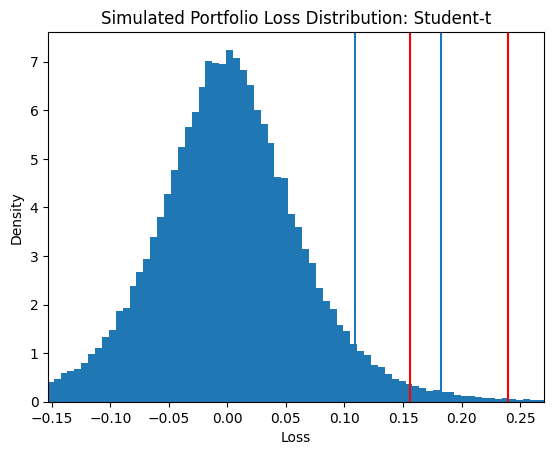

In [12]:
plot_t_pnl_distribution(sim_t_port_returns, sim_gaussian_port_returns, var_t_95, var_t_99, cvar_t_95, cvar_t_99)

In [13]:
print(np.std(sim_t_port_returns))
print(np.mean(sim_t_port_returns))

0.06921398385768811
-0.00016555451984543026


In [14]:
#CVaR comparison
print(cvar_t_99 / cvar_gaussian_99)

1.6719877445924787


In [15]:
#Backtesting

In [16]:
var_level = 0.99

breaches_gaussian, _ = backtest_var(rets, weights=weights, var_level=var_level, model='gaussian')
breaches_t, _ = backtest_var(rets, weights=weights, var_level=var_level, model='student-t')

In [ ]:
#check gaussian breach rate
gaussian_empirical_rate = breaches_gaussian.mean()
gaussian_expected_rate = 1 - var_level

print(f'expected breach rate: {gaussian_expected_rate}')
print(f'empirical breach rate: {gaussian_empirical_rate}')

#kupiec test
gau_kup_LR, gau_kup_pval = kupiec_test(breaches_gaussian, var_level)
print(gau_kup_pval)


print(
    f"Gaussian Kupiec p-value = {gau_kup_pval:.3f}. "
    "At the 5% significance level, we reject the null hypothesis of 99% VaR coverage through the Gaussian model."
)
print(
    "This indicates the Gaussian model is inaccurate at forecasting 
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.022675736961451247
0.02174481888289337
Gaussian Kupiec p-value = 0.022. At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage.
This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, though tail risk remains less robustly modeled than under the Student-t specification.


In [18]:
#check student-t breach rate
t_empirical_rate = breaches_t.mean()
t_expected_rate = 1 - var_level

print(f'expected breach rate: {t_expected_rate}')
print(f'empirical breach rate: {t_empirical_rate}')

#kupiec test
t_kup_LR, t_kup_pval = kupiec_test(breaches_t, var_level)
print(t_kup_pval)

if t_kup_pval < 0.05:
    print(f'as kupiec p-value = {t_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')
else:
    print(
    f"Student-t Kupiec p-value = {t_kup_pval:.3f} vs Gaussian = {gau_kup_pval:.3f}. "
    "The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, "
    "suggesting better tail-risk calibration."
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.011337868480725623
0.7821950933494567
Student-t Kupiec p-value = 0.782 vs Gaussian = 0.022. The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, suggesting better tail-risk calibration.


In [19]:
#check student-t breach rate
t_empirical_rate = breaches_t.mean()
t_expected_rate = 1 - var_level

print(f'expected breach rate: {t_expected_rate}')
print(f'empirical breach rate: {t_empirical_rate}')

#kupiec test
t_kup_LR, t_kup_pval = kupiec_test(breaches_t, var_level)
print(t_kup_pval)

if t_kup_pval < 0.05:
    print(f'as kupiec p-value = {t_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')
else:
    print(
    f"Student-t Kupiec p-value = {t_kup_pval:.3f} vs Gaussian = {gau_kup_pval:.3f}. "
    "The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, "
    "suggesting better tail-risk calibration."
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.011337868480725623
0.7821950933494567
Student-t Kupiec p-value = 0.782 vs Gaussian = 0.022. The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, suggesting better tail-risk calibration.
